### Import Modules

In [52]:
import re
import string
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from keras.models import Sequential 
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn import metrics

### Import Dataset Files

In [25]:
Psy = pd.read_csv("Dataset/Youtube01-Psy.csv")
Katy = pd.read_csv("Dataset/Youtube02-KatyPerry.csv")
LMFAO = pd.read_csv("Dataset/Youtube03-LMFAO.csv")
Eminem = pd.read_csv("Dataset/Youtube04-Eminem.csv")
Shakira = pd.read_csv("Dataset/Youtube05-Shakira.csv")

In [26]:
df = pd.concat([Psy, Katy, LMFAO, Eminem, Shakira])
df.drop(['COMMENT_ID', 'AUTHOR', 'DATE'], axis=1, inplace=True)
df.head()

,CONTENT,CLASS
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [27]:
df['COMMENT_LEN'] = df['CONTENT'].apply(lambda x: len(x.split(' ')))
df.head()

,CONTENT,CLASS,COMMENT_LEN
0,"Huh, anyway check out this you[tube] channel: ...",1,8
1,Hey guys check out my new channel and our firs...,1,32
2,just for test I have to say murdev.com,1,8
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,11
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,7


### Balance Class Distribution

In [28]:
balance_counts = df.groupby('CLASS')['CLASS'].agg('count').values
balance_counts

array([ 951, 1005], dtype=int64)

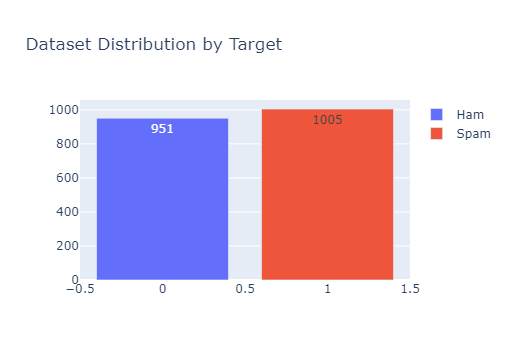

In [29]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x = [0],
    y = [balance_counts[0]],
    name = 'Ham',
    text = [balance_counts[0]],
    textposition = 'auto'
))
fig.add_trace(go.Bar(
    x = [1],
    y = [balance_counts[1]],
    name = 'Spam',
    text = [balance_counts[1]],
    textposition = 'auto'
))
fig.update_layout(title = 'Dataset Distribution by Target')
fig.show()

##### Dataset Distribution is Already Balanced

### Data Preprocessing

In [30]:
def clean_text(text):
    '''Make text lowercase, 
    remove text in square brackets, 
    remove links, 
    remove punctuation and 
    remove words containing numbers.'''
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [31]:
stop_words = stopwords.words('english')

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [32]:
stemmer = nltk.SnowballStemmer('english')

def stem_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [33]:
def preprocess_data(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text = stem_text(text)
    return text

In [34]:
df['CLEAN_COMMENTS'] = df['CONTENT'].apply(preprocess_data)
df.head()

,CONTENT,CLASS,COMMENT_LEN,CLEAN_COMMENTS
0,"Huh, anyway check out this you[tube] channel: ...",1,8,huh anyway check channel
1,Hey guys check out my new channel and our firs...,1,32,hey guy check new channel first vid us monkey...
2,just for test I have to say murdev.com,1,8,test say murdevcom
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,11,shake sexi ass channel enjoy ﻿
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,7,watchvvtarggvgtwq check ﻿


### Tokenization

In [35]:
comments = df['CLEAN_COMMENTS']
target = df['CLASS']

In [36]:
max_features = 2000
word_tokenizer = Tokenizer(num_words=max_features, split=' ')
word_tokenizer.fit_on_texts(comments)

### Pad Sequences

In [37]:
longest_train = max(comments, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

In [38]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

train_padded_sentences = pad_sequences(
    embed(comments), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

array([[ 861, 1312,    1, ...,    0,    0,    0],
       [  21,   14,    1, ...,    0,    0,    0],
       [1314,  167, 1315, ...,    0,    0,    0],
       ...,
       [ 138,    0,    0, ...,    0,    0,    0],
       [  85,   34,    0, ...,    0,    0,    0],
       [  85,   26,    0, ...,    0,    0,    0]])

### Splitting Dataset into Train and Test Sets

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences,
    target,
    test_size=0.25
)

In [40]:
def glove_lstm():
    embed_dim = 128
    lstm_out = 196
    
    model = Sequential()
    
    model.add(Embedding(
        max_features,
        embed_dim,
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = glove_lstm()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 101, 128)          256000    
                                                                 
 bidirectional (Bidirectiona  (None, 101, 202)         185840    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 202)              0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 202)              808       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 202)               0         
                                                      

In [44]:
mdoel = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
46/46 [==============================] - ETA: 0s - loss: 0.5186 - accuracy: 0.7403
Epoch 1: val_loss improved from inf to 0.61656, saving model to model.h5
46/46 [==============================] - 8s 105ms/step - loss: 0.5186 - accuracy: 0.7403 - val_loss: 0.6166 - val_accuracy: 0.8712 - lr: 0.0010
Epoch 2/7
46/46 [==============================] - ETA: 0s - loss: 0.3087 - accuracy: 0.8773
Epoch 2: val_loss improved from 0.61656 to 0.55318, saving model to model.h5
46/46 [==============================] - 4s 97ms/step - loss: 0.3087 - accuracy: 0.8773 - val_loss: 0.5532 - val_accuracy: 0.8814 - lr: 0.0010
Epoch 3/7
46/46 [==============================] - ETA: 0s - loss: 0.2248 - accuracy: 0.9182
Epoch 3: val_loss improved from 0.55318 to 0.49174, saving model to model.h5
46/46 [==============================] - 4s 98ms/step - loss: 0.2248 - accuracy: 0.9182 - val_loss: 0.4917 - val_accuracy: 0.9121 - lr: 0.0010
Epoch 4/7
46/46 [==============================] - ETA: 0s - los

In [45]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

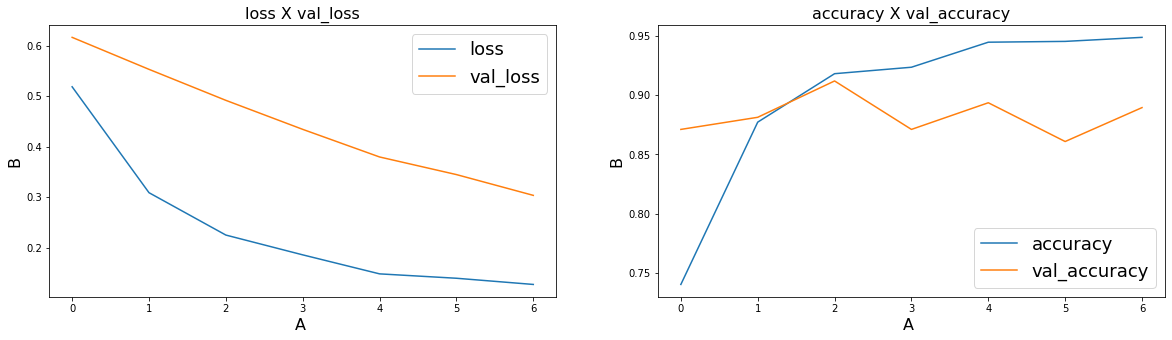

In [50]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [54]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")
metrics.confusion_matrix(y_test, y_preds)

array([[198,  21],
       [ 33, 237]], dtype=int64)